<a href="https://colab.research.google.com/github/aaditya0710/PERFECT-CAR-PARKING/blob/master/Correct_Car_Parking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing

# Implementation of Hough Transform

In [2]:
def houghLines(edges, dTheta, threshold):
    imageShape = edges.shape
    imageDiameter = (imageShape[0]**2 + imageShape[1]**2)**0.5
    rhoRange = [i for i in range(int(imageDiameter)+1)]
    thetaRange = [dTheta*i for i in range(int(-np.pi/(2*dTheta)), int(np.pi/dTheta))]
    cosTheta = [np.cos(theta) for theta in thetaRange]
    sinTheta = [np.sin(theta) for theta in thetaRange]
    countMatrix = np.zeros([len(rhoRange), len(thetaRange)])
    eds = [(x,y) for (x,y), value in np.ndenumerate(edges) if value > 0]
    for thetaIndex in range(len(thetaRange)):
        theta = thetaRange[thetaIndex]
        cos = cosTheta[thetaIndex]
        sin = sinTheta[thetaIndex]
        for x, y in eds:
            targetRho = x*cos + y*sin
            closestRhoIndex = int(round(targetRho))
            countMatrix[closestRhoIndex, thetaIndex] += 1
    #print(countMatrix)  
    lines = [(p,thetaRange[t]) for (p,t), value in np.ndenumerate(countMatrix) if value > threshold]
    return np.array([lines])

# Parallel Implementation of Hough Transform

In [3]:
class CountMatrix():
    def __init__(self,m,n):
      self.countMatrix=np.zeros([m,n])
    
    def Calc_countMatrix(self,edges,rhoRange,thetaRange,thetaIndex):
      cosTheta = [np.cos(theta) for theta in thetaRange]
      sinTheta = [np.sin(theta) for theta in thetaRange]
      eds = [(x,y) for (x,y), value in np.ndenumerate(edges) if value > 0]

      theta = thetaRange[thetaIndex]
      cos = cosTheta[thetaIndex]
      sin = sinTheta[thetaIndex]
      for x, y in eds:
        targetRho = x*cos + y*sin
        closestRhoIndex = int(round(targetRho))
        self.countMatrix[closestRhoIndex, thetaIndex] += 1
      
def houghLines(edges, dTheta, threshold):
  imageShape = edges.shape
  imageDiameter = (imageShape[0]**2 + imageShape[1]**2)**0.5
  rhoRange = [i for i in range(int(imageDiameter)+1)]
  thetaRange = [dTheta*i for i in range(int(-np.pi/(2*dTheta)), int(np.pi/dTheta))]
    
  countMatrixObject = CountMatrix(len(rhoRange), len(thetaRange))


  #a_pool = multiprocessing.Pool()
  #a_pool.starmap(countMatrixObject.Calc_countMatrix,[(edges,rhoRange,thetaRange,thetaIndex) for thetaIndex in range(len(thetaRange))])
  for thetaIndex in range(len(thetaRange)):
    countMatrixObject.Calc_countMatrix(edges,rhoRange,thetaRange,thetaIndex)
    
  #print(countMatrix)     
  lines = [(p,thetaRange[t]) for (p,t), value in np.ndenumerate(countMatrixObject.countMatrix) if value > threshold]
  return np.array([lines])

# Application: Identification of Correct and Incorrect Car Parking

In [77]:
Test_image="/content/CarParking_0.jpeg"

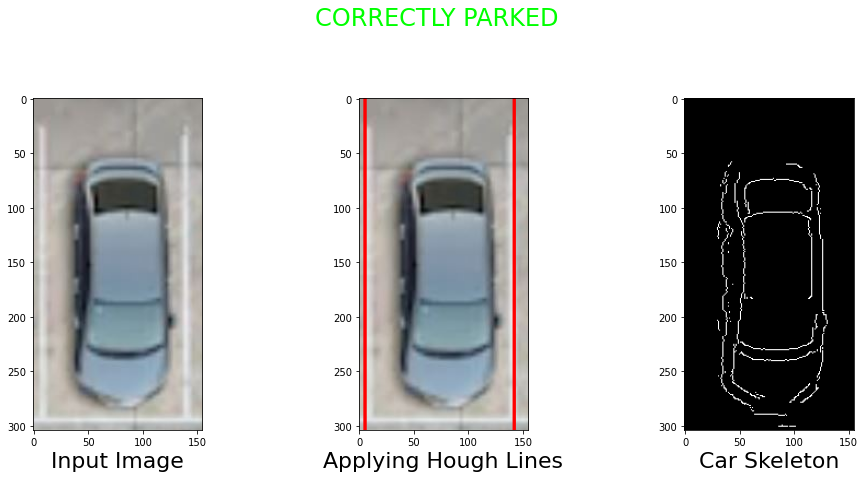

In [78]:
img = cv2.imread(Test_image)
img2 = img.copy()
gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
pts = []
for aperturesize in [5,7]:
    edges = cv2.Canny(gray,25,100,apertureSize = aperturesize)
        
    if Test_image=="/content/CarParking_2.jpg":
      lines = houghLines(edges,3,80)#Needs to be adjusted for each image
      #print(lines)
    else:
      lines = cv2.HoughLines(edges,1,np.pi/180,30)
    
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(img2,(x1,y1),(x2,y2),(0,0,255),2)
        pts.append(x1)
      
if Test_image=="/content/CarParking_0.jpeg":
  blurred = cv2.blur(img,(10,10))
elif Test_image=="/content/CarParking_1.jpeg":
  blurred = cv2.blur(img,(30,20))
  blurred = cv2.blur(blurred,(10,15))
elif Test_image=="/content/CarParking_2.jpg":
  blurred = cv2.blur(img,(20,20))

edges = cv2.Canny(blurred,50,60)

arr=[]
for i in range(edges.shape[1]):
    for j in range(edges.shape[0]):
        if edges[j][i]!=0:
            arr.append(i)

if max(pts)>=max(arr) and min(pts)<=min(arr):
    output = "CORRECTLY PARKED"
    color=(0,1,0)
else:
    output = "INCORRECTLY PARKED"
    color=(1,0,0)

plt.figure(figsize=(15,8))
plt.suptitle(output,fontsize=24,color=color)
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.xlabel("Input Image",fontsize=22)
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.xlabel("Applying Hough Lines",fontsize=22)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(edges,cv2.COLOR_BGR2RGB))
plt.xlabel("Car Skeleton",fontsize=22)
plt.tight_layout(pad=10.0)
plt.show()